In [253]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [2]:
# Read CSV files
dataset = pd.read_csv('/Users/xiaoxinzhou/Documents/IFT6758_M2_CSV_data/all_data.csv')

In [107]:
dataset.head()

,eventIdx,game_id,Distance from Net,Angle from Net,Is Goal,Is Net Empty
0,5,2015020364,43.829214,27.149682,0,0
1,12,2015020364,13.416408,26.565051,0,0
2,13,2015020364,12.369317,-75.963757,0,0
3,18,2015020364,9.899495,45.000000,0,0
4,32,2015020364,42.201896,-13.706961,0,0


In [3]:
# Separate features and labels 
X = dataset[['eventIdx', 'game_id', 'Distance from Net',
             'Angle from Net', 'Is Net Empty']]
y = dataset[['Is Goal']]

In [16]:
# ==========================================================================================
# Question 1: 
# ==========================================================================================
def q3_1(X, y):
    '''
    Using only the 'distance' feature, train a Logistic Regression classifier 
    with the completely default settings.    
    '''
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[['Distance from Net']],y,test_size=0.20,random_state=50)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)

    # Predict on validation set
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f'Accuracy score is {accuracy}')
    # Accuracy score is 0.9039567998457138
    
q3_1(X, y)

Accuracy score is 0.9039567998457138


In [278]:
# ==========================================================================================
# Question 2:
# ==========================================================================================
def q3_2(X, y, features=['Distance from Net']):
    '''
     Calculate the probability.
     In X_test_pred_proba, the first column is label 0, the second one is label 1.  
    '''
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # use clf.classes_ to check the order of labels     

    # Predict the probability
    X_test_pred_proba = clf.predict_proba(X_test)

    # print(f'The probabilities on validation set is\n {X_test_pred_proba}')
    
    return X_test_pred_proba

q3_2(X, y)

array([[0.92323014, 0.07676986],
       [0.88364339, 0.11635661],
       [0.88192328, 0.11807672],
       ...,
       [0.90970915, 0.09029085],
       [0.85868169, 0.14131831],
       [0.8929553 , 0.1070447 ]])

In [279]:
q3_2(X,y,features=['Angle from Net'])

array([[0.90745049, 0.09254951],
       [0.90561567, 0.09438433],
       [0.90556204, 0.09443796],
       ...,
       [0.90500797, 0.09499203],
       [0.90770823, 0.09229177],
       [0.90488637, 0.09511363]])

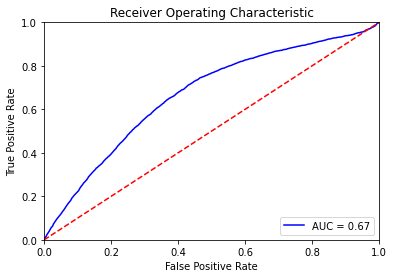

In [7]:
def q3_2_roc(X, y, probs):
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[['Distance from Net']],y,test_size=0.20,random_state=50)
    is_goal = probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
probs = q3_2(X, y)
q3_2_roc(X, y, probs)

In [280]:
def get_percentile(X, y, probs, features=['Distance from Net']):
    '''
    Return a df that has four columns:
        * 'index': index in y_test.
        * 'Goal prob': Goal probability.
        * 'Is Goal': 0 means not goal; 1 means goal.
        * 'Percentile': Calculated percentile, range from 0.00 to 99.99.
    The df is sorted by 'Percentile'.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)

    # Create a df for shot probabilities
    probs_df = pd.DataFrame(probs)
    probs_df = probs_df.rename(columns={0: "Not Goal prob", 1: "Goal prob"})

    # Concatenate 'Goal Probability' and 'Is Goal' into one df. Each column has values: 0 and 1. 
    df = pd.concat([probs_df["Goal prob"].reset_index(drop=True),\
                    y_test["Is Goal"].reset_index(drop=True)],axis=1)

    # Add 'Percentile' column
    percentile_series=df['Goal prob'].rank().apply(lambda x: 100.0*(x-1)/df.shape[0])
    df['Percentile'] = percentile_series

    # Sort the df by the value of percentile. Min is 0.0000, max is 99.9967
    df = df.sort_values(by=['Percentile'])
    df = df.reset_index()
    
    return df

In [281]:
perc_df = get_percentile(X, y, probs)
perc_df.head(10)

,index,Goal prob,Is Goal,Percentile
0,36250,0.005271,0,0.000000
1,49783,0.005300,0,0.001607
2,2062,0.005390,0,0.003214
3,23325,0.005393,1,0.004821
4,59590,0.005502,1,0.006429
5,7908,0.005509,0,0.008839
6,17520,0.005509,0,0.008839
7,49587,0.005514,0,0.011250
8,29105,0.005519,1,0.012857
9,28713,0.005534,0,0.014464


In [284]:
angle_probs = q3_2(X,y,features=['Angle from Net'])
angle_perc_df = get_percentile(X, y, angle_probs, features=['Angle from Net'])
angle_perc_df.head(10)

,index,Goal prob,Is Goal,Percentile
0,6996,0.089956,0,0.041786
1,41031,0.089956,0,0.041786
2,10098,0.089956,1,0.041786
3,18289,0.089956,0,0.041786
4,43707,0.089956,0,0.041786
5,29780,0.089956,0,0.041786
6,44531,0.089956,0,0.041786
7,57170,0.089956,0,0.041786
8,25758,0.089956,0,0.041786
9,16201,0.089956,0,0.041786


In [225]:
def get_rate(df, function_type='goal_rate'):
    '''
    Divide the sorted df into 10 bins, each two adjacent bins have a difference of 10 on percentile.
    As we noticed, the percentile ranges from 0 to 99.99, we set bin range from 0 to 100, 
    so, there are 10 bins: [0:10], [10:20], ..., [90:100].
    Given function type, calculates the corresponding rate. 
    
    :params df: A sorted percentile df, calculated by get_percentile().
    :params function_type: Function type. Default value 'goal_rate'. 
                           Another option is 'cumulative_rate'.
    
    :return goal_rate_df: A df has shape (10, 2). First column is rate, second column is bin index. 
    '''
    
    # In goal_rate function, the list should have a length of 10, 
    # each item is the goal rate of that bin. 
    # For example, if there are 5000 records have percentiles between 0 and 10, 
    # and there are 250 goals, the goal rate is 250/5000=0.05.
    # So, rate_list[0] is 0.05
    rate_list = []
    
    # Find total number of goals
    total_goals = df['Is Goal'].value_counts()[1]
    
    cumulative_counts = 0

    i = 0
    i_list = []
    
    # 91 is the lower bound of last bin
    while i<92:
        i_list.append(i)

        # current bin size
        lower_bound = i
        upper_bound = (i+10)

        # find all records that have percentiles fall in this range
        rows = df[(df['Percentile']>=lower_bound) &
                  (df['Percentile']<upper_bound)]
        
        # count the number of goals
        goals = rows['Is Goal'].value_counts()[1]

        shots = rows.shape[0]

        if function_type == 'goal_rate':
            rate = goals/shots
            
        elif function_type == 'cumulative_rate':
            cumulative_counts += goals
            rate = (cumulative_counts)/total_goals

        rate_list.append(rate)

        i+=10

    rate_list = [i*100 for i in rate_list]    
    
    # Combine goal rate list and percentile list into one df
    rate_df = pd.DataFrame(list(zip(rate_list, i_list)),\
                                columns=['Rate', 'Percentile'])
    
    return rate_df

goal_rate_df = get_rate(perc_df)
goal_rate_df

,Rate,Percentile
0,6.072289,0
1,3.530733,10
2,3.545528,20
3,4.738510,30
4,6.247950,40
5,9.395973,50
6,12.275641,60
7,14.777849,70
8,15.883489,80
9,19.569754,90


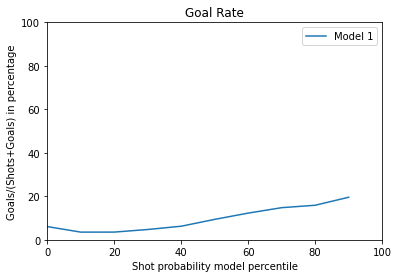

In [233]:
def plot_baseline_rates(df, x, y, function_type='goal_rate'):
    ax = plt.gca()
    plt.plot(
        df[x],
        df[y],
    )
    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    
    ax.legend(['Model 1'])
    
    plt.xlabel('Shot probability model percentile')
    
    if function_type == 'goal_rate':
        plt.title('Goal Rate')
        plt.ylabel('Goals/(Shots+Goals) in percentage')
    
    elif function_type == 'cumulative_rate':
        plt.title('Cumulative % of goals')
        plt.ylabel('Proportion')        
    
    plt.show()

plot_baseline_rates(goal_rate_df, 'Percentile', 'Rate')

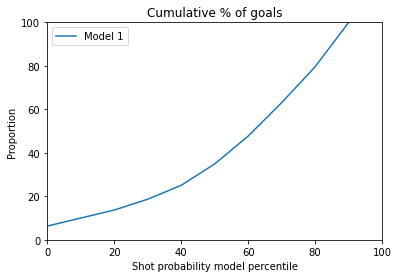

In [234]:
cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 
plot_baseline_rates(cumulative_rate, 'Percentile', 'Rate', function_type='cumulative_rate')

In [232]:
cumulative_rate

,Rate,Percentile
0,6.325301,0
1,10.006693,10
2,13.688086,20
3,18.691432,30
4,25.066934,40
5,34.906292,50
6,47.724230,60
7,63.085676,70
8,79.601740,80
9,100.000000,90


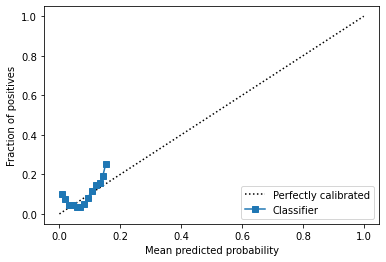

In [252]:
# reliability diagram
def plot_calibration(df):

    disp = CalibrationDisplay.from_predictions(df['Is Goal'], df['Goal prob'],n_bins=80)
    
plot_calibration(perc_df)    

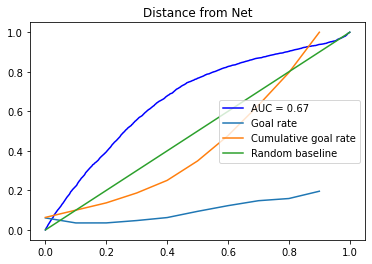

In [285]:
# ==========================================================================================
# Question 3:
# ==========================================================================================
def logistic_reg(X, y, features=['Distance from Net']):
    '''
    :params features: A list. Possible items are 'Distance from Net', 'Angle from Net', and both.    
    '''
    #--------------------------------------
    # Training model
    #--------------------------------------
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)
    
    #--------------------------------------
    # Calculate goal probability
    #--------------------------------------  
    probs = q3_2(X, y, features)
    is_goal = probs[:,1]
    
    #--------------------------------------
    # ROC
    #--------------------------------------
    fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(
        fpr, 
        tpr, 
        'b', 
        label = 'AUC = %0.2f' % roc_auc)
    

    #--------------------------------------
    # Goal rate
    #--------------------------------------  
    perc_df = get_percentile(X, y, probs, features) 
    goal_rate_df = get_rate(perc_df)
    plt.plot(
        goal_rate_df['Percentile']/100,
        goal_rate_df['Rate']/100,
        label = 'Goal rate'
    )
    
    #--------------------------------------
    # Cumulative proportion of goals
    #--------------------------------------  
    cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 
    plt.plot(
        cumulative_rate['Percentile']/100,
        cumulative_rate['Rate']/100,
        label = 'Cumulative goal rate'
    )
    
    #--------------------------------------
    # Random baseline
    #-------------------------------------- 
    plt.plot(
        [0, 1], 
        [0, 1], 
        label='Random baseline')
    
    if len(features)==2:
        title = 'Feature: Distance and Angle'
    else:
        title = features[0]
        
    plt.title(title)
    plt.legend()

    
distance_only = logistic_reg(X, y)

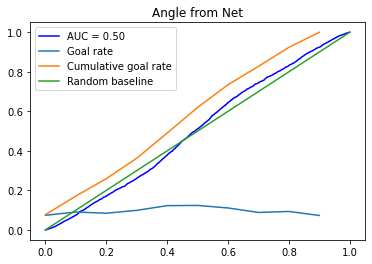

In [286]:
angle_only = logistic_reg(X, y, features=['Angle from Net'])

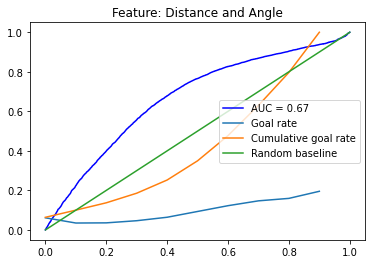

In [287]:
both_features = logistic_reg(X, y, features=['Distance from Net', 'Angle from Net'])